In [39]:
import cirq
# Create the first quantum circuit with 3 qubits
circuit1 = cirq.Circuit()
qubits1 = [cirq.LineQubit(i) for i in range(4)]

# Add gates to the first circuit
circuit1.append(cirq.H(qubits1[0]))  # Hadamard gate on qubit 0
circuit1.append(cirq.CNOT(qubits1[0], qubits1[1]))  # CNOT gate between qubits 0 and 1
circuit1.append(cirq.X(qubits1[2]))  # X gate on qubit 2
circuit1.append(cirq.X(qubits1[3]))  # X gate on qubit 2

# Print the first circuit
print("First circuit:")
print(circuit1)

final_qubits = [cirq.LineQubit(i) for i in range(12)]
final_circuit = cirq.Circuit()
initial_qubits = [cirq.LineQubit(i) for i in range(4)]

for i in range(3):
    
    final_circuit += circuit1.transform_qubits(qubit_map={initial_qubits[j]:final_qubits[j+i*4] for j in range(4)})


final_circuit

#print(list((circuit1.all_qubits())))
#(circuit1.all_qubits())

First circuit:
0: ───H───@───
          │
1: ───────X───

2: ───X───────

3: ───X───────


0: ────H───@───────────────────
           │
1: ────────X───────────────────

2: ────X───────────────────────

3: ────X───────────────────────

4: ────────────H───@───────────
                   │
5: ────────────────X───────────

6: ────────────X───────────────

7: ────────────X───────────────

8: ────────────────────H───@───
                           │
9: ────────────────────────X───

10: ───────────────────X───────

11: ───────────────────X───────

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from numpy import linalg as LA
import copy
import itertools

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit


2023-07-06 14:46:33.736186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64::/usr/local/cuda-10.2/lib64/
2023-07-06 14:46:33.736212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-06 14:46:37.533086: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-06 14:46:37.533131: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (claudio-CG8270): /proc/driver/nvidia/version does not exist
2023-07-06 14:46:37.533711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to us

## Functions for amplitude encoding

In [2]:
def gen_angles(x):
    """function that generates angles for amplitude encoding"""
    
    if len(x)>1:
        new_x = np.zeros(int(len(x)/2))
        
        for k in range(len(new_x)):
            new_x[k] = np.sqrt(x[2*k]**2 + x[2*k+1]**2)
        
        inner_angles = gen_angles(new_x)
                
        angles = np.zeros(int(len(x)/2))

        for k in range(len(new_x)):
            if(new_x[k]!=0):
                if(x[2*k]>0):
                    angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
                else:
                    angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
            else:
                angles[k] = 0
        
        angles = np.concatenate((inner_angles, angles))
        
        return np.array(angles)
    
    else: return np.ones(0)
    
    
    
n_0 = 20  # Number of elements in the array
array = [0] * n_0  # Initialize the array with zeros

# Calculate the cumulative sums of powers of 2
for i in range(n_0):
    if i == 0:
        array[i] = 1
    else:
        array[i] = array[i-1] + 2 ** i
array = np.array(array)-1



def level(k):
    
    for i in range(len(array)):
        
        if(k==0): return 0
        
        if (k>array[i] and k<=array[i+1]): return i+1
    


def parity(level):
    
    n = level
    combinations = list(itertools.product([0, 1], repeat=n))
    return (combinations)
    
def gen_circuit(qubits, angles): #recive a list of n qubits
    
    circuit = cirq.Circuit()
    counter = 0
    levels = [level(np.arange(0,len(angles)+1)[i]) for i in range(len(angles)+1)]


    for k in range(len(angles)):
        
        j = levels[k]
        
        if(j!=levels[k-1] and k>0):
            counter = 0
        
        p = parity(j)
        op = cirq.ry(angles[k]).on(qubits[j]).controlled_by(*qubits[0:j], control_values=parity(j)[counter])
        #for i in range(j):
         #   op = op.controlled_by(qubits[j-1-i], control_values=[1])
        
        counter += 1
        circuit += op

    return circuit

In [3]:
def amplitude_encoding(qubits, data, print_it=False):
    
    """ Make amplitude encoding. Return the circuit """
    
    N = len(data) #dimension of the vector
    n = np.log2(N) #number of qubits
    
    angles = np.hstack(gen_angles(data)) #compute the angles to do amp encoding

    circuit = gen_circuit(qubits, angles) #make the circuit
    
    if (print_it==True):
        SVGCircuit(circuit)
        
    return circuit

In [4]:
def quantum_fc_circuit(bits, symbols, Fcc = True):
    #Pay attention on the number of parameters needed: 
    circuit = cirq.Circuit()
    '''for i in range(len(bits)):
        circuit += one_qubit_unitary(bits[i], symbols[3*i: 3*(i+1)])
    n = len(bits)*3'''
    if(Fcc):
        #needed 3*3*len(bits)+6
        #counter for the params
        n = 0
        # hyperparams 0 < r < len(bits)
        r = 1
        # indixes of the qbits where to apply the gate
        j = 0
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n + 6*i: n + 6*(i)+3])
            #cz = cirq.CZ(qubits[0], qubits[1])
            k = (j+r)%len(bits)
            if(k == 0 ): k = len(bits)
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 6*i]
            #print("CZ", i, j, (j+r)%len(bits))
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 6*i + 1]
            #print("CX", i, j, (j+r)%len(bits))
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 6*i + 2]
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 6*i + 2]
            
            #print("Control on :", (j+r)%len(bits))
            
            circuit += one_qubit_unitary(bits[j], symbols[n + 6*(i)+3: n + 6*(i+1)])
            
            j = (j+r)%len(bits)
            
        n = n + (2*len(bits))*3
        
        circuit += one_qubit_unitary(bits[0], symbols[n : n + 3])
        
        n = n + 3
        
        #print("\n")
        #change hyperparameters
        r = 2
        j = 0
        
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n+3*i:n+3*(i)+3])
            
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 3*i]
            #print("CZ", i, j, (j+r)%len(bits))
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 1]
            #print("CX", i, j, (j+r)%len(bits))
            circuit += cirq.CZ(bits[(j+r)%len(bits)], bits[j])**symbols[n + 3*i + 2]
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]
            
            #circuit += cirq.ControlledGate(ui).on(bits[j], bits[(j+r)%len(bits)])
            #circuit += one_qubit_unitary(bits[(j+r)%len(bits)], symbols[n+6*(i)+3: n+6*(i+1)])
            j = (j+r)%len(bits)
            
            #print("Control on :", j)
            
        n = n + (len(bits))*3
        circuit += one_qubit_unitary(bits[j], symbols[n: n+3])  
        n = n + 3
        #print("Number of params needed", n)
        return circuit
    
    
    elif(Fcc == False):
        #needed 3*4*length(bit)+6 parameters
        for i in range(len(bits)):
            circuit.append(one_qubit_unitary(bits[i], symbols[3*i: 3*(i+1)]))
        n = len(bits)*3
        r = 1
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n + 6*i: n + 6*(i)+3])
            
            circuit += cirq.CZ(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i]
            circuit += cirq.CX(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 1]
            circuit += cirq.CZ(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 2]
            circuit += cirq.CX(bits[i], bits[(i+r)%len(bits)])**symbols[n + 6*i + 2]            
           
            #circuit += cirq.ControlledGate(ui).on(bits[i], bits[(i+r)%len(bits)])
            circuit += one_qubit_unitary(bits[i], symbols[n + 6*(i)+3: n + 6*(i+1)])
        n = n + (2*len(bits))*3
        
        circuit += one_qubit_unitary(bits[0], symbols[n : n + 3])
        
        n = n + 3
        
        r = 2
        j = 0
        for i in range(len(bits)):
            #ui = one_gate_unitary(symbols[n+3*i:n+3*(i)+3])
            
            circuit += cirq.CZ(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i]
            
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 1]
            
            circuit += cirq.CZ(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]
            circuit += cirq.CX(bits[j], bits[(j+r)%len(bits)])**symbols[n + 3*i + 2]    
            
            #circuit += cirq.ControlledGate(ui).on(bits[j], bits[(j+r)%len(bits)])
            #circuit += one_qubit_unitary(bits[(j+r)%len(bits)], symbols[n+6*(i)+3: n+6*(i+1)])
            j = (j+r)%len(bits)
        n = n + (len(bits))*3
        circuit += one_qubit_unitary(bits[j], symbols[n: n+3])    
        n = n + 3
        #print("Number of params needed", n)
        return circuit
    


## Functions of general circuits

In [5]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

def qfcc_3q(bits, symbols):
    """Make a 3 qubit quantum FCC"""
    
    circuit = cirq.Circuit()

    circuit += cirq.Y(bits[0])**(symbols[0])
    circuit += cirq.Y(bits[1])**(symbols[1])
    circuit += cirq.Y(bits[2])**(symbols[2])

    circuit += cirq.Z(bits[0])**(symbols[3])
    circuit += cirq.Z(bits[1])**(symbols[4])
    circuit += cirq.Z(bits[2])**(symbols[5])

    circuit += cirq.CNOT(bits[0], bits[1])
    circuit += cirq.CNOT(bits[0], bits[2])
    circuit += cirq.CNOT(bits[1], bits[2])

    circuit += cirq.Y(bits[0])**(symbols[6])
    circuit += cirq.Y(bits[1])**(symbols[7])
    circuit += cirq.Y(bits[2])**(symbols[8])

    circuit += cirq.Z(bits[0])**(symbols[9])
    circuit += cirq.Z(bits[1])**(symbols[10])
    circuit += cirq.Z(bits[2])**(symbols[11])

    circuit += cirq.CNOT(bits[0], bits[1])
    circuit += cirq.CNOT(bits[0], bits[2])
    circuit += cirq.CNOT(bits[1], bits[2])

    circuit += cirq.Y(bits[0])**(symbols[12])
    circuit += cirq.Y(bits[1])**(symbols[13])
    circuit += cirq.Y(bits[2])**(symbols[14])
    
    return circuit


In [6]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
        
    return circuit


def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

## Visualization of pooling and convulational layers

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

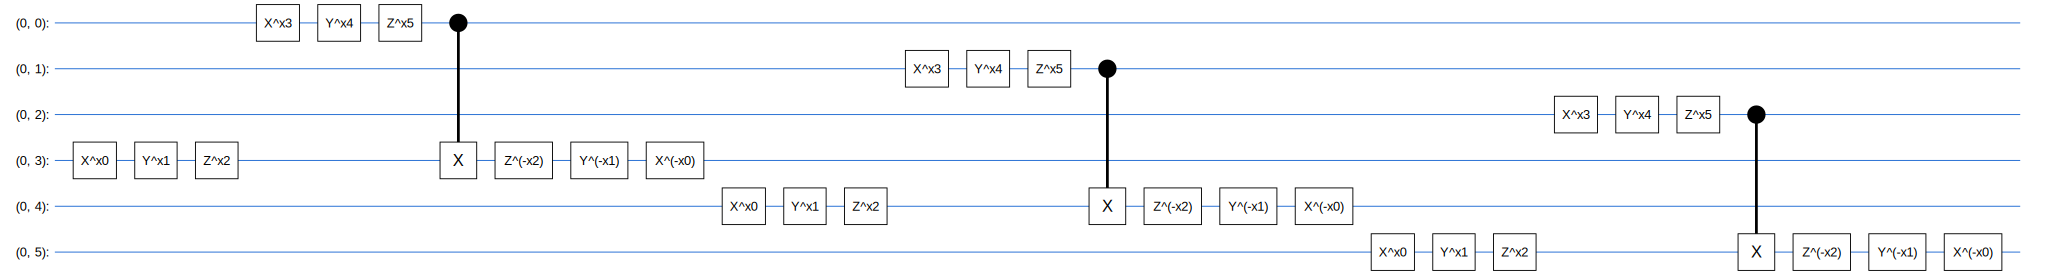

In [7]:
#plot che pooling circuit

test_bits = cirq.GridQubit.rect(1, 6)

SVGCircuit(
    quantum_pool_circuit(test_bits[:3], test_bits[3:], sympy.symbols('x0:6')))


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

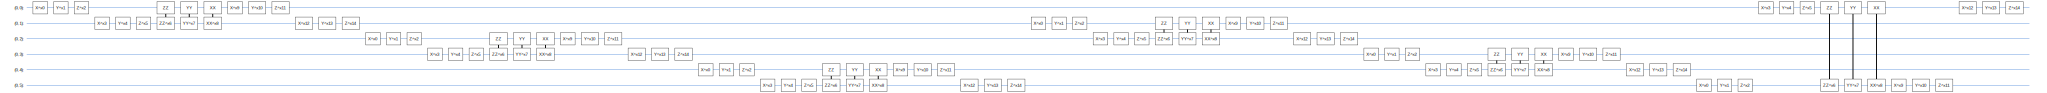

In [8]:
#plot the convulational circuit

SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 6), sympy.symbols('x0:15')))


## Create the model
Decide how many convulational layers, pooling etc....

In [9]:
def create_model_circuit(qubitss):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:168')

    for i in [0,1,2]:
        qubits = qubitss[i*4:i*4+4]
        sym = symbols[i*18:i*18+18]
        model_circuit += two_qubit_unitary([qubits[-2], qubits[-1]], sym[0:15])
        model_circuit += one_qubit_unitary(qubits[-1], sym[15:18])

        
        
    model_circuit += quantum_fc_circuit(qubitss, symbols[54:168])
    
    
    #model_circuit += (cirq.r(symbols[36]) * cirq.Y(symbols[36])).controlled_by(qubits[5])
    
    #cirq.ControlledGate(cirq.rx(symbols[36]) * cirq.ry(symbols[37]) * cirq.rz(symbols[38])).on(qubits[4], qubits[5])
    #model_circuit += cirq.ControlledGate(my_U).on(qubits[4], qubits[5])
    #model_circuit += cirq.Circuit(custom_gate.on(*qubits[2:4]))
    #model_circuit += quantum_fc_circuit(qubits[3:], symbols[36:75])

    
    return model_circuit


from tensorflow_quantum import differentiators


qubits = cirq.GridQubit.rect(1, 12) #grid of qubit 
readout_operators = cirq.Z(qubits[0]) #grid of operator i want to average on (final expected value)

# Build a sequential model enacting the logic in 1.3 of this notebook.
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string) #still general input

#define the differentiator
#differentiator = differentiators.ParameterShift()


#apply three differrnt filters with a qfcc in the end
quantum_model = tfq.layers.PQC(create_model_circuit(qubits),readout_operators)(inputs)


qcnn_model = tf.keras.Model(inputs=[inputs], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

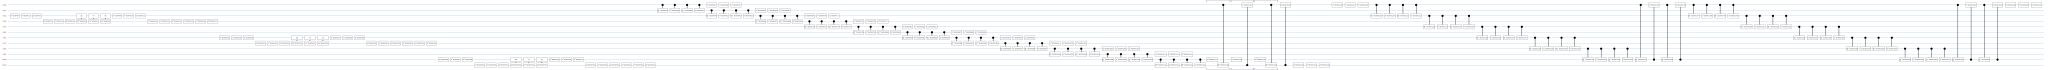

In [10]:
SVGCircuit(create_model_circuit(qubits))

## Load data of amplitude encoding

In [11]:
import json

# Open the file in read mode
with open('amplitude_encoding_train_4pixelSquareChuncks_4x4img.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
train_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((5000))]

# Open the file in read mode
with open('amplitude_encoding_test_4pixelSquareChuncks_4x4img.json', 'r') as f:
    # Use json.load() to read the contents of the file
    new_circuit = json.load(f)

# Close the file
f.close()
test_circuits_data = [cirq.read_json(json_text=new_circuit[i]) for i in range((500))]

y_train = np.loadtxt("y_train.txt")
y_test = np.loadtxt("y_test.txt")

y_train = y_train[:5000]
y_test = y_test[:500]


In [12]:
#repeat vertically the encoding three times (3 multiple filters)

#for k in range(5000):
    
  #  final_circuit = cirq.Circuit()
    
 #   for i in range(3):

   #     final_circuit += train_circuits_data[k].transform_qubits(qubit_map={[cirq.LineQubit(i) for i in range(4)][j]:qubits[j+i*4] for j in range(4)})
  #  
   # train_circuits_data[k] = final_circuit


In [13]:
# convert to tensors
train_circuits_data = tfq.convert_to_tensor(train_circuits_data)
test_circuits_data = tfq.convert_to_tensor(test_circuits_data)

In [14]:

# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])


In [ ]:
history = qcnn_model.fit(x=train_circuits_data,
                         y=y_train,
                         batch_size=64,
                         epochs=50,
                         verbose=1,
                         validation_data=(test_circuits_data, y_test))


Epoch 1/50
79/79 [==============================] - 43s 536ms/step - loss: 0.6080 - custom_accuracy: 0.8799 - val_loss: 0.5354 - val_custom_accuracy: 0.8869
Epoch 2/50
79/79 [==============================] - 41s 521ms/step - loss: 0.4003 - custom_accuracy: 0.9169 - val_loss: 0.4603 - val_custom_accuracy: 0.8990
Epoch 3/50
79/79 [==============================] - 41s 525ms/step - loss: 0.3477 - custom_accuracy: 0.9181 - val_loss: 0.4321 - val_custom_accuracy: 0.8995
Epoch 4/50
79/79 [==============================] - 41s 519ms/step - loss: 0.3281 - custom_accuracy: 0.9144 - val_loss: 0.4180 - val_custom_accuracy: 0.8873
Epoch 5/50
79/79 [==============================] - 41s 516ms/step - loss: 0.3181 - custom_accuracy: 0.9215 - val_loss: 0.4102 - val_custom_accuracy: 0.9014
Epoch 6/50
79/79 [==============================] - 41s 516ms/step - loss: 0.3118 - custom_accuracy: 0.9195 - val_loss: 0.4043 - val_custom_accuracy: 0.8936
Epoch 7/50
79/79 [==============================] - 42s 52

In [1]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

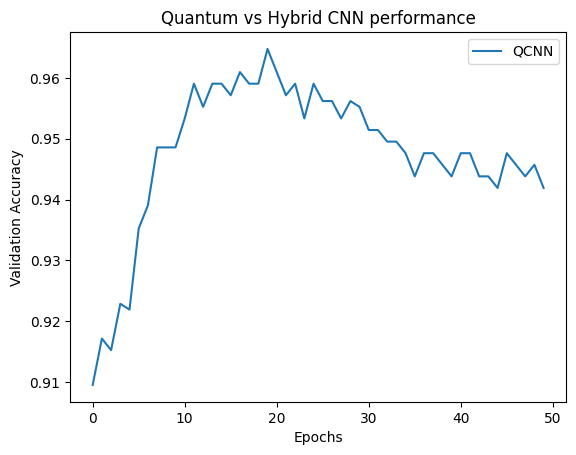

In [20]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()
